## [Description](#Description_)
## [Todo](#Todo_)
## [Research](#Research_)
## [Imports](#Imports_)
## [Globals](#Globals_)
## [Setup](#Setup_)
## [Data](#Data_)
### - [Annotation structure](#Annotation_structure_)
## [Data exploration](#Data_exploration_)
## [Model](#Model_)
## [Training](#Training_)
## [Results](#Results_)

## Description <span id=Description_></span>

Trying my hand at this kaggle challenge

https://www.kaggle.com/competitions/benetech-making-graphs-accessible

## Todo <span id=Todo_></span>

- Visualize image sizes, channels
- Make video out of graphs
- Preprocess images
- Debug/train/val/test splits; only extracted in val/test
- Check out dataset https://chartinfo.github.io/toolsanddata.html
- Try ready models as baselines:
    - https://www.kaggle.com/competitions/benetech-making-graphs-accessible/code
    - https://github.com/huggingface/pytorch-image-models
- Try segmentation -> classification -> parsing pipeline

## Research <span id=Research_></span>

## Imports <span id=Imports_></span>

In [15]:
%load_ext nb_black


import dataclasses
import enum
import glob
import IPython
import imageio
import json
import functools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import reprlib
import torch
import tqdm.autonotebook

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


/tmp/ipykernel_3148529/1608468528.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook


<IPython.core.display.Javascript object>

## Globals <span id=Globals_></span>

In [3]:
COMPETITION = "benetech-making-graphs-accessible"

<IPython.core.display.Javascript object>

## Setup <span id=Setup_></span>

### Markdown

In [4]:
def make_new_markdown_section_with_link(section, header="##", do_print=True):
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header


def make_several_sections(
    section_names=(
        "Description",
        "Imports",
        "Globals",
        "Setup",
        "Data",
        "Data exploration",
        "Model",
        "Training",
        "Results",
    )
):
    links, headers = zip(
        *[
            make_new_markdown_section_with_link(sn, do_print=False)
            for sn in section_names
        ]
    )
    print("\n".join(links + ("",) + headers))

<IPython.core.display.Javascript object>

### Terminal

In [5]:
def mkdir(path, error_if_exists=False):
    !mkdir {"-p" if not error_if_exists else ""} {path}


def unzip(zip_path, save_path=None, delete_zip=False):
    !unzip {zip_path} {"-d "+ save_path if save_path else ""}
    if delete_zip:
        for path in glob.glob(zip_path):
            if path.endswith(".zip"):
                !trash {path}


def unzip_to_data_and_delete():
    unzip("data/*", "data", delete_zip=True)

<IPython.core.display.Javascript object>

### Kaggle

In [6]:
def kaggle_competitions_search(search_term):
    !kaggle competitions list -s {search_term}


def kaggle_competitions_files(competition):
    !kaggle competitions files {competition}


def kaggle_competitions_download(competition, save_path="data", filename=None):
    mkdir(save_path)
    !kaggle competitions download -p {save_path} {"-f " + filename if filename else ""} {competition}


def kaggle_competitions_submit(competition, filename, message="submit"):
    !kaggle competitions submit -f {filename} -m {message} {competition}


def kaggle_competitions_submissions(competition):
    !kaggle competitions submissions {competition}

<IPython.core.display.Javascript object>

## Data <span id=Data_></span>

In [19]:
#kaggle_competitions_download(COMPETITION)
#unzip_to_data_and_delete()

100%|███████████████████████████████████████▉| 968M/969M [01:34<00:00, 10.8MB/s]
100%|████████████████████████████████████████| 969M/969M [01:35<00:00, 10.7MB/s]


<IPython.core.display.Javascript object>

## Data exploration <span id=Data_exploration_></span>

In [7]:
def path_to_dict(path, print_only_last_dirname=False):
    dirpath, dirnames, filenames = next(os.walk(path))
    path_contents = filenames
    
    for dirname in dirnames:
        full_dirname = os.path.join(path, dirname)
        path_contents.append(path_to_dict(full_dirname, print_only_last_dirname=True))
        
    if print_only_last_dirname:
        path = os.path.split(path)[-1]
        
    return {path: path_contents}

def pprint_path_contents(path):
    path_dict = path_to_dict(path)
    short_path_repr = reprlib.repr(path_dict)
    short_path_dict = eval(short_path_repr)
    string = pprint.pformat(short_path_dict).replace("Ellipsis", "...")
    print(string)


<IPython.core.display.Javascript object>

In [8]:
pprint_path_contents("data")

{'data': ['sample_submission.csv',
          {'train': [{'images': ['52ecbd029a07.jpg',
                                 'fd7e3f0e4d43.jpg',
                                 'f0122da6cbe1.jpg',
                                 '2a186a0fa1ae.jpg',
                                 '6559c7a7d153.jpg',
                                 '5fd880333d07.jpg',
                                 ...]},
                     {'annotations': ['0f4f52fc3f4b.json',
                                      '35f0ec146509.json',
                                      '2e374a37e404.json',
                                      '96578b79c571.json',
                                      'dfbd6e21c301.json',
                                      '0893be463049.json',
                                      ...]}]},
          {'test': [{'images': ['000b92c3b098.jpg',
                                '01b45b831589.jpg',
                                '00dcf883a459.jpg',
                                '007a18eb4e09.jpg'

<IPython.core.display.Javascript object>

In [9]:
@functools.cache
def load_train_image_ids() -> list[str]:
    return [i.replace(".jpg", "") for i in os.listdir("data/train/images")]


def load_test_image_ids() -> list[str]:
    return [i.replace(".jpg", "") for i in os.listdir("data/test/images")]


def load_image_annotation(image_id: str) -> dict:
    return json.load(open(f"data/train/annotations/{image_id}.json"))


def load_image(image_id: str) -> np.ndarray:
    return imageio.v3.imread(open(f"data/train/images/{image_id}.jpg", "rb"))


def plot_random_images(n_rows=2, n_cols=2):
    image_ids = load_train_image_ids()
    np.random.shuffle(image_ids)

    figure, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))

    for axis, image_id in zip(figure.axes, image_ids):
        plt.sca(axis)
        plt.axis("off")
        plt.imshow(load_image(image_id))

    plt.tight_layout()

<IPython.core.display.Javascript object>

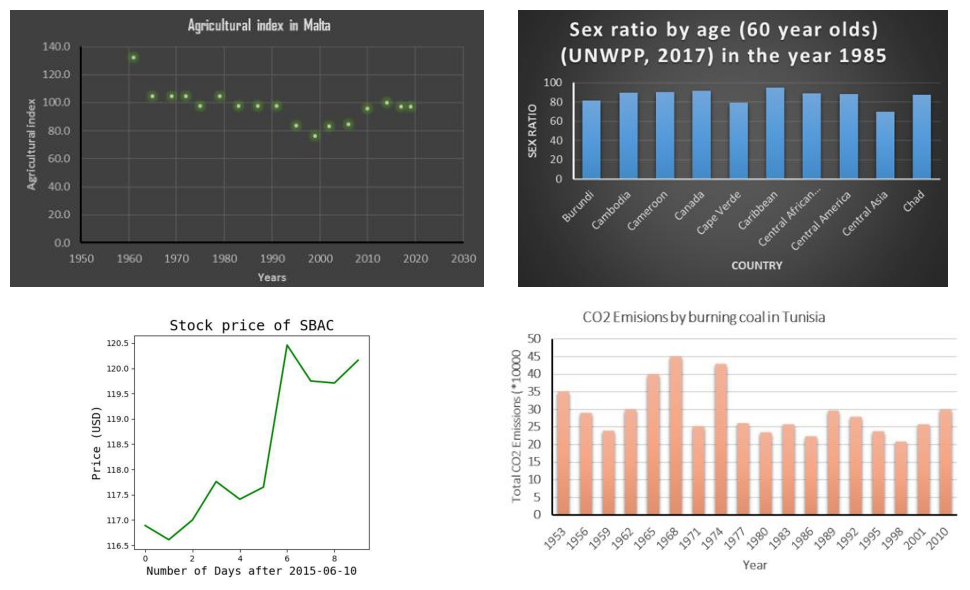

<IPython.core.display.Javascript object>

In [10]:
plot_random_images()

In [11]:
pd.read_csv("data/sample_submission.csv").head(4)

,id,data_series,chart_type
0,000b92c3b098_x,abc;def,vertical_bar
1,000b92c3b098_y,0.0;1.0,vertical_bar
2,007a18eb4e09_x,abc;def,vertical_bar
3,007a18eb4e09_y,0.0;1.0,vertical_bar


<IPython.core.display.Javascript object>

In [17]:
def convert_dashes_to_underscores_in_key_names(dictionary):
    return {k.replace("-", "_"): v for k, v in dictionary.items()}


class Source(enum.Enum):
    generated = "generated"
    extracted = "extracted"


class ChartType(enum.Enum):
    dot = "dot"
    horizontal_bar = "horizontal_bar"
    vertical_bar = "vertical_bar"
    line = "line"
    scatter = "scatter"


@dataclasses.dataclass
class PlotBoundingBox:
    height: int
    width: int
    x0: int
    y0: int


@dataclasses.dataclass
class DataPoint:
    x: int or float or str
    y: int or float or str


class TextRole(enum.Enum):
    axis_title = "axis_title"
    chart_title = "chart_title"
    legend_label = "legend_label"
    tick_grouping = "tick_grouping"
    tick_label = "tick_label"
    other = "other"


@dataclasses.dataclass
class Polygon:
    x0: int
    x1: int
    x2: int
    x3: int
    y0: int
    y1: int
    y2: int
    y3: int


@dataclasses.dataclass
class Text:
    id: int
    polygon: Polygon
    role: TextRole
    text: str

    def __post_init__(self):
        self.polygon = Polygon(**self.polygon)
        self.role = TextRole(self.role)


class ValuesType(enum.Enum):
    categorical = "categorical"
    numerical = "numerical"


@dataclasses.dataclass
class Tick:
    id: int
    x: int
    y: int


class TickType(enum.Enum):
    markers = "markers"
    separators = "separators"


@dataclasses.dataclass
class Axis:
    values_type: ValuesType
    tick_type: TickType
    ticks: list[Tick]

    def __post_init__(self):
        self.values_type = ValuesType(self.values_type)
        self.tick_type = TickType(self.tick_type)
        self.ticks = [
            Tick(id=kw["id"], x=kw["tick_pt"]["x"], y=kw["tick_pt"]["y"])
            for kw in self.ticks
        ]


@dataclasses.dataclass
class Axes:
    x_axis: Axis
    y_axis: Axis

    def __post_init__(self):
        self.x_axis = Axis(**convert_dashes_to_underscores_in_key_names(self.x_axis))
        self.y_axis = Axis(**convert_dashes_to_underscores_in_key_names(self.y_axis))


@dataclasses.dataclass
class Annotation:
    source: Source
    chart_type: ChartType
    plot_bb: PlotBoundingBox
    data_series: list[DataPoint]
    text: list[Text]
    axes: Axes

    def __post_init__(self):
        self.source = Source(self.source)
        self.chart_type = ChartType(self.chart_type)
        self.plot_bb = PlotBoundingBox(**self.plot_bb)
        self.data_series = [DataPoint(**kw) for kw in self.data_series]
        self.text = [Text(**kw) for kw in self.text]
        self.axes = Axes(**convert_dashes_to_underscores_in_key_names(self.axes))

    @staticmethod
    def from_dict_with_dashes(kwargs):
        return Annotation(**convert_dashes_to_underscores_in_key_names(kwargs))

<IPython.core.display.Javascript object>

In [13]:
def test_annotations():
    for image_id in tqdm.autonotebook.tqdm(
        load_train_image_ids(), desc="Trying to read all annotations."
    ):
        Annotation.from_dict_with_dashes(load_image_annotation(image_id))


def test_images():
    for image_id in tqdm.autonotebook.tqdm(
        load_train_image_ids(), desc="Trying to read all images."
    ):
        dict_annotation = load_image_annotation(image_id)
        dict_annotation = convert_dashes_to_underscores_in_key_names(dict_annotation)
        load_image(image_id)

<IPython.core.display.Javascript object>

In [18]:
test_annotations()

Trying to read all annotations.:   0%|          | 0/60578 [00:00<?, ?it/s]

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [19]:
test_images()

Trying to read all images.:   0%|          | 0/60578 [00:00<?, ?it/s]

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

### Annotation structure <span id=Annotation_structure_></span>

In [20]:
def plot_image_with_annotations(image_id):
    annotation = Annotation.from_dict_with_dashes(load_image_annotation(image_id))
    image = load_image(image_id)
    plt.subplots(figsize=(8, 6))
    plt.imshow(image)

    IPython.display.display(
        pd.Series(
            dict(
                source=annotation.source.value,
                chart_type=annotation.chart_type.value,
                x_values_type=annotation.axes.x_axis.values_type.value,
                y_values_type=annotation.axes.y_axis.values_type.value,
                x_tick_type=annotation.axes.x_axis.tick_type.value,
                y_tick_type=annotation.axes.y_axis.tick_type.value,
            )
        )
    )

    box = annotation.plot_bb
    xs = [box.x0, box.x0 + box.width, box.x0 + box.width, box.x0, box.x0]
    ys = [box.y0, box.y0, box.y0 + box.height, box.y0 + box.height, box.y0]
    plt.plot(xs, ys, c="cyan", label="bounding_box")

    plt.scatter(
        *list(zip(*[[tick.x, tick.y] for tick in annotation.axes.x_axis.ticks])),
        label="x_ticks"
    )
    plt.scatter(
        *list(zip(*[[tick.x, tick.y] for tick in annotation.axes.y_axis.ticks])),
        label="y_ticks"
    )

    text_role_colors = dict(zip(TextRole, plt.cm.Accent.colors))
    seen_roles = set()
    for i, text in enumerate(annotation.text):
        xs = [
            text.polygon.x0,
            text.polygon.x1,
            text.polygon.x2,
            text.polygon.x3,
            text.polygon.x0,
        ]
        ys = [
            text.polygon.y0,
            text.polygon.y1,
            text.polygon.y2,
            text.polygon.y3,
            text.polygon.y0,
        ]
        plt.plot(
            xs,
            ys,
            c=text_role_colors[text.role],
            label=text.role.value if text.role not in seen_roles else None,
        )
        seen_roles.add(text.role)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

<IPython.core.display.Javascript object>

source              generated
chart_type       vertical_bar
x_values_type     categorical
y_values_type       numerical
x_tick_type           markers
y_tick_type           markers
dtype: object

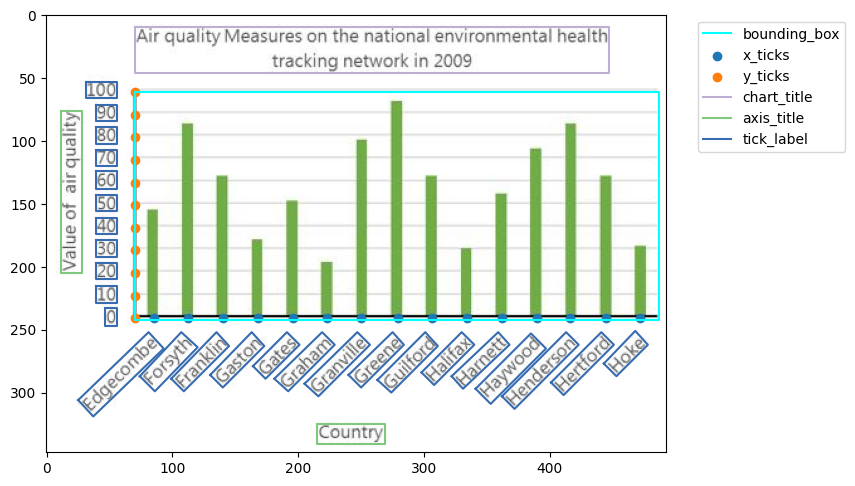

<IPython.core.display.Javascript object>

In [21]:
plot_image_with_annotations(np.random.choice(load_train_image_ids()))

## Model <span id=Model_></span>

## Training <span id=Training_></span>

## Results <span id=Results_></span>